The purpose of this exercise will be to look at how L1 regularization can be used to force sparse weights of features in our model to zero, reducing size and memory constraints while still preserving predictive power. We will be applying L1 regularization to the classification task we developed in our last exercise.

By using L1 regularization, we reduce complexity of our model and encourage sparse weights to be zero (essentially, increasing sparsity). This helps to avoid overfitting and (hopefully) improve efficiency and RAM usage. 

We begin in our usual way, setting up the functions to import libraries, process features/targets and split our dataset up.

In [3]:
#to bring print function from later versions of python into this one
from __future__ import print_function
import math
from IPython import display

#for data visualization & interaction
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

#support for higher dimensional objects in data manipulation
import numpy as np
import pandas as pd
from sklearn import metrics


import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

#so we are not flooded with output anytime we print out the results
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

#DONT FORGET TO RANDOMIZE THE DATA!
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))



In [4]:
"""Pre-processes input features from California Housing Dataset
    Args:
        california_housing_dataframe: A pandas dataframe with
        data from the California Housing Dataset
    Returns:
        A dataframe containing the features to be used for the model
        including synthetic features

"""
def preprocess_features(california_housing_dataframe):
    
    selected_features = california_housing_dataframe[[
        "latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income"
    ]]
    
    processed_features = selected_features.copy()
    
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"]/
        california_housing_dataframe["population"])
    
    return processed_features


""" Prepare target features or labels
    Args:
        california_housing_dataframe: A pandas dataframe with
        data from the California Housing Dataset
    Returns:
        A pandas dataframe containing target features

"""
def preprocess_targets(california_housing_dataframe):

    output_targets = pd.DataFrame()
    #essentially, fill column with boolean then casting to a float 1,0 (automatic cast for booleans)
    output_targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    
    return output_targets


In [5]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print("Training examples summary")
display.display(training_examples.describe())

print("Validation examples summary")
display.display(validation_examples.describe())

print("Training targets summary")
display.display(training_targets.describe())

print("Validation targets summary")
display.display(validation_targets.describe())

Training examples summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2669.1,544.4,1438.7,505.5,3.9,2.0
std,2.1,2.0,12.6,2230.8,430.5,1146.9,393.1,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1467.8,297.0,791.0,282.0,2.6,1.5
50%,34.3,-118.5,29.0,2134.5,435.0,1170.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3171.0,655.0,1733.0,609.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.5,2582.5,527.4,1407.6,491.0,3.9,2.0
std,2.1,2.0,12.5,2051.8,398.8,1150.1,362.9,1.9,1.0
min,32.5,-124.3,1.0,8.0,1.0,13.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1446.0,295.0,786.8,282.0,2.6,1.5
50%,34.2,-118.5,29.0,2111.5,430.0,1159.0,407.0,3.6,1.9
75%,37.7,-118.0,37.0,3102.2,636.0,1694.0,593.0,4.7,2.3
max,41.9,-114.6,52.0,32054.0,5290.0,35682.0,5050.0,15.0,34.2


Training targets summary


,median_house_value_is_high
count,12000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


Validation targets summary


,median_house_value_is_high
count,5000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Next, we define our input function

In [6]:
"""Trains a linear regression model.
    Args: 
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Int size of batches to be passed to the model
        shuffle: Boolean of whether to shuffle the data
        epochs: Int Number of epochs for which data should be repeated.
            default value = None
    Returns:
        Tuple of (features, labels) for the next data batch
    
""" 
def my_input_func(features, targets, batch_size = 1, shuffle = True, num_epochs = None):
    
    #converts pandas data into a dict of numpy arrays
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    #constructs dataset and configures batching/repeating
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    #shuffle data, if specified by user
    if shuffle:
        ds = ds.shuffle(10000)
    
    #return next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    
    return features, labels

Since this is a lesson in sparsity, lets create bins for ALL of our feature columns to coerce a higher dimensional feature space to actually utilize and note the effect of L1. We do this below:


In [7]:
def get_quantile_based_buckets(feature_values, num_buckets):
    
    quantiles = feature_values.quantile(
        [(i+1.0)/(num_buckets + 1.0) for i in range(num_buckets)])
    
    return [quantiles[q] for q in quantiles.keys()]


In [8]:
"""
Helper function to return bucketized feature columns (helps increase code reuse)

    Args:
        feature: string feature to be bucketized
        num_buckets: int number of buckets feature to be split into
    
    Returns:
        the bucketized columns

"""
def bucketized_helper(feature, num_buckets = 10):
    
    curr_feature = tf.feature_column.bucketized_column(
        tf.feature_column.numeric_column(feature),
        boundaries = get_quantile_based_buckets(training_examples[feature], num_buckets))

    return curr_feature


    
"""Construct TF feature columns. In this example, bucketizes all features. 

    Returns: 
        set of feature columns

"""

def construct_feature_columns():
    
    bucketized_households = bucketized_helper("households")
    bucketized_longitude = bucketized_helper("longitude", 50)
    bucketized_latitude = bucketized_helper("latitude", 50)
    bucketized_housing_median_age = bucketized_helper("housing_median_age")
    bucketized_total_rooms = bucketized_helper("total_rooms")
    bucketized_total_bedrooms = bucketized_helper("total_bedrooms")
    bucketized_population = bucketized_helper("population")
    bucketized_median_income = bucketized_helper("median_income")
    bucketized_rooms_per_person = bucketized_helper("rooms_per_person")
    
    long_x_lat = tf.feature_column.crossed_column(
        set([bucketized_longitude, bucketized_latitude]), hash_bucket_size = 1000)
    
    feature_columns = set([
        long_x_lat,
        bucketized_households,
        bucketized_longitude,
        bucketized_latitude,
        bucketized_housing_median_age,
        bucketized_total_rooms,
        bucketized_total_bedrooms,
        bucketized_population,
        bucketized_households,
        bucketized_median_income,
        bucketized_rooms_per_person
    ])
    
    return feature_columns
    
    

Now, lets write a function to get a better idea of our model size. Apparently, according to the team at google responsible for the machine learning crash course, the following function uses "intimate knowledge" of the estimators API. I also dont have to "worry about understanding how it works". 

Really? Really Google? I honestly tried for an hour to understand how the following function worked and couldnt make anything of it. The least they could have done is provide a reference to help understanding (because god only knows what the documentation in the Tensorflow estimators API actually means, coming from a complete noob ofcourse). 

At the risk of my inner nerd sounding butthurt af, Lets just copy down what they wrote...

In [16]:
def model_size(estimator):
    variables = estimator.get_variable_names()
    size = 0
    for variable in variables:
        
        if not any(x in variable
                   for x in ['global step',
                             'centered_bias_weight',
                             'bias_weight',
                             'Ftrl']
                  ):
            size += np.count_nonzero(estimator.get_variable_value(variable))
    
    return size

Lets apply some constraints to the model we are about to specify and try to get a model with no more than 600 parameters and a Logloss under 0.35 by using L1 regularization. 

We are going to apply the Ftrl optimizer designed to give better results with L1 regularization than standard gradient descent.

The question does remain however: How strong does the regularization strength have to be? Too low and there wont be a significant reduction in the parameters of our model but too high and it will adversely affect the classification loss. 

Lets take a look!

In [17]:
"""This function trains a linear classification model of multiple features

    Args:
        learning_rate: A 'float', learning rate
        steps: A non-zero 'int', total training steps taken (each step is forward
            and backward pass using single batch)
        batch_size: A non-zero 'int', the batch size
        training_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for validation.
            
    Returns:
        A LinearClassifier object trained on training data
        Plots log loss value at each training period step 

"""
def train_linear_classifier_model(learning_rate, regularization_strength, steps, batch_size,
                                  feature_columns, training_examples, training_targets,
                                  validation_examples, validation_targets):
    
    #decided to reduce our total period number since we are using the entire dataset this
        #time around and should expect the Ftrl optimizer to work alot slower
    periods = 7
    steps_per_period = steps/periods
    
    #Create our linear classifier object
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns = feature_columns,
        optimizer = my_optimizer
    )
    
    #Create our input functions
    training_input_func = lambda: my_input_func(training_examples,
                                                training_targets["median_house_value_is_high"],
                                                batch_size = batch_size)
    
    predict_training_input_func = lambda: my_input_func(training_examples,
                                                        training_targets["median_house_value_is_high"],
                                                        num_epochs = 1,
                                                        shuffle = False)
    
    predict_validation_input_func = lambda: my_input_func(validation_examples,
                                                          validation_targets["median_house_value_is_high"],
                                                          num_epochs = 1,
                                                          shuffle = False)
    
    #train model in loop, iteratively calculating and displaying loss metrics
    print("Training model...")
    print("Logloss (on validation data):")
    
    training_log_losses = []
    validation_log_losses = []
    
    for period in range (0, periods):
        
        linear_classifier.train(
            input_fn = training_input_func,
            steps = steps_per_period
        )
        
        #compute training and validation predictions
        training_probabilities = linear_classifier.predict(input_fn = predict_training_input_func)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
        
        validation_probabilities = linear_classifier.predict(input_fn = predict_validation_input_func)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
        
        #compute training, validation loss and append to lists
        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        training_log_losses.append(training_log_loss)
        
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        validation_log_losses.append(validation_log_loss)
        
        #print current loss
        print("  period %02d: %0.2f" % (period, validation_log_loss))
        
    print("Model training complete!")
    
    #Graph loss metrics
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label = "training")
    plt.plot(validation_log_losses, label = "validation")
    plt.legend()
    
    return linear_classifier
        

Training model...
Logloss (on validation data):
  period 00: 0.31
  period 01: 0.28
  period 02: 0.27
  period 03: 0.26
  period 04: 0.25
  period 05: 0.25
  period 06: 0.24
Model training complete!
Model size:  742


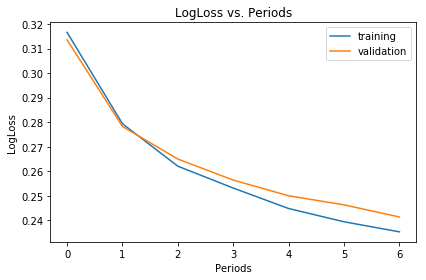

In [19]:
linear_classifier = train_linear_classifier_model(
    learning_rate = 0.1,
    regularization_strength = 0.3,
    steps = 300,
    batch_size = 100,
    feature_columns = construct_feature_columns(),
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets)

print("Model size: ", model_size(linear_classifier))

I did play around with this for a bit before settling on 0.30 (it is also the value provided as a solution in the mlcc lecture). (WARNING: it did take about 5 minutes to train so dont be surprised if it seems like nothing is happening at first). 

So thats about it for this part of the lecture series. The next few lectures are going to be on creating and tuning neural networks, so we are going to take a complete 180 with regards to the model being covered. 

Before then, I point you to a resource I found really helpful to get an intuitive understanding of what goes on behind the scenes in an ordinary neural network by one of my favorite math youtubers [here](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi). 

Although the focus is on deep learning (think neural networks on steroids), I still highly reccomend watching the 4 videos in the playlist before moving on to the next lecture to get a very clear picture on what a neural network is actually doing. 